# QuTiP example: Nonlinear Response of the Vacuum Rabi Resonance
Akash Levy and Katie Blume

For more information about QuTiP see http://qutip.org

## Setup

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from qutip.ui.progressbar import TextProgressBar as ProgressBar
qutip.settings.has_mkl = False

In [3]:
# System parameters (in GHz)
omega_r = 6.92E9 * 2 * np.pi / 1E9        # Resonator frequency
omega_C1 = 400E6 * 2 * np.pi / 1E9        # Frequency associated with charging energy of qubit 1
omega_C2 = 340E6 * 2 * np.pi / 1E9        # Frequency associated with charging energy of qubit 2
omega_J = omega_r                         # Frequency associated with Josephson energy

g0_q1 = 347E6 * np.pi / 1E9               # Ground state coupling coefficient for qubit 1
g0_q2 = 94.4E6 * np.pi / 1E9              # Ground state coupling coefficient for qubit 2

swt_spot = 0
T_1_q1 = 1.4E-6 if swt_spot else 1.7E-6
T_2_q1 = 2.8E-6 if swt_spot else 0.7E-6
gamma_1 = 2 * np.pi / T_1_q1 / 1E9        # Rate of intrinsic relaxation of transmon excitations
gamma_phi = 0                             # Rate of pure dephasing of cavity photons (unused, ignored)
kappa = 300E3 * 2 * np.pi / 1E9           # Rate of loss of cavity photons

alpha = omega_C1                          # Anharmonicity of JC ladder (to first order)

In [4]:
# Helper functions
def g_j(j):
    return g0_q1 * np.sqrt(j+1)
def alpha_j(j):
    return g_j(j) / g0_q1
def omega_j(j):
    return np.sqrt(8 * omega_C1 * omega_J) * (j + 1./2) - omega_C1 / 12 * (6*j**2 + 6*j + 3) - omega_J
def j_braket(j1,j2):
    if j1 >= N_atom or j2 >= N_atom:
        return tensor(qeye(N_light), identity(N_atom)-identity(N_atom))
    return tensor(qeye(N_light), fock(N_atom, j1) * fock(N_atom, j2).dag())

In [5]:
# Simulation parameters
N_light = 7
N_atom = 2

## Figure 2: Supersplitting of the vacuum Rabi resonance when probing heterodyne transmission beyond linear response

In [6]:
# Vary the driving force
xi_dbs = np.linspace(-70, -28, (70-28)*2+1)            # Driving strengths
omega_ds = np.linspace(7.08, 7.11, 200) * 2 * np.pi    # Driving frequencies

In [7]:
# Find transmission amplitude for varying frequencies
results = []
pbar = ProgressBar(len(xi_dbs))
for i, xi_db in enumerate(xi_dbs):
    # Convert decibel to magnitude
    xi = 10**(xi_db/20)

    # Operators
    a = tensor(destroy(N_light), qeye(N_atom))
    sm = tensor(qeye(N_light), destroy(N_atom))
    
    # Solve master equation for different driving frequencies
    results.append([])
    for omega_d in omega_ds:
        # Hamiltonian
        H_res = (omega_r-omega_d) * a.dag() * a
        H_qub = (omega_r-omega_d) * sm.dag() * sm #sum([(omega_j(j)-omega_d) * j_braket(j,j) for j in range(N_atom)])
        H_int = g_j(0) * (a * sm.dag() + sm * a.dag()) #sum([g_j(j) * (a * j_braket(j+1,j) + j_braket(j,j+1) * a.dag()) for j in range(N_atom)])
        H_drv = xi * (a.dag() + a)
        H = H_res + H_qub + H_int + H_drv

        # Collapse operators
        damping = kappa * a
        relaxation = gamma_1 * alpha_j(0) * sm #gamma_1 * sum([alpha_j(j) * j_braket(j,j+1) for j in range(N_atom-1)])
        c_ops = [damping, relaxation]
        
        # Steady-state solution of master equation
        rho_s = steadystate(H, c_ops)
        results[-1].append(np.abs(expect(a, rho_s))**2)
    
    # Update progress bar
    pbar.update(i)

10.6%. Run time:  11.04s. Est. time left: 00:00:01:33
20.0%. Run time:  19.88s. Est. time left: 00:00:01:19
30.6%. Run time:  29.89s. Est. time left: 00:00:01:07
40.0%. Run time:  38.67s. Est. time left: 00:00:00:57
50.6%. Run time:  48.58s. Est. time left: 00:00:00:47
60.0%. Run time:  57.39s. Est. time left: 00:00:00:38
70.6%. Run time:  67.27s. Est. time left: 00:00:00:28
80.0%. Run time:  76.06s. Est. time left: 00:00:00:19
90.6%. Run time:  87.25s. Est. time left: 00:00:00:09


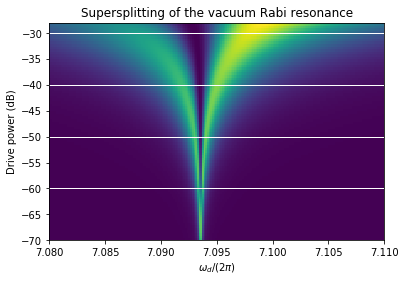

In [8]:
# Generate pseudocolor plot of transmission amplitude response over parameter space
plt.title('Supersplitting of the vacuum Rabi resonance')
plt.xlabel('$\omega_d / (2 \pi)$')
plt.ylabel('Drive power (dB)')
for i in range(-30, -70, -10):
    plt.plot(omega_ds/(2*np.pi),[i]*len(omega_ds), 'w', linewidth=1)
plt.pcolor(omega_ds/(2*np.pi), xi_dbs, results)
plt.show()

-60.5 dB


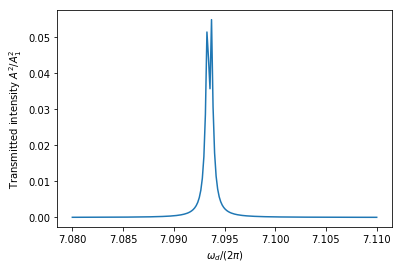

-60.0 dB


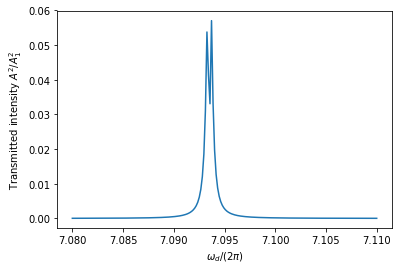

-50.5 dB


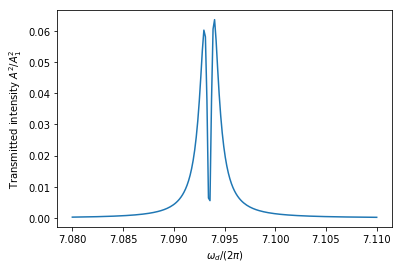

-50.0 dB


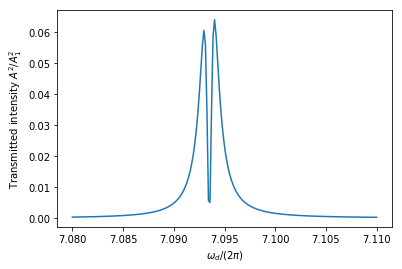

-40.5 dB


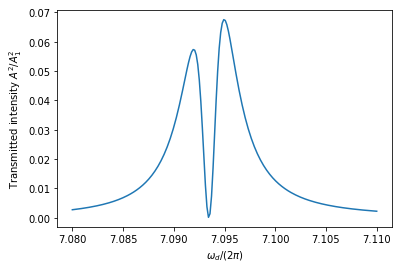

-40.0 dB


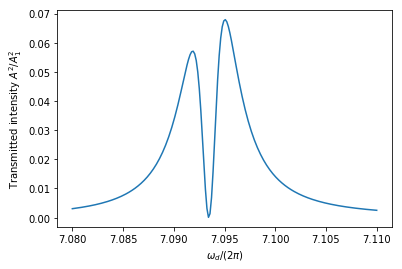

-30.5 dB


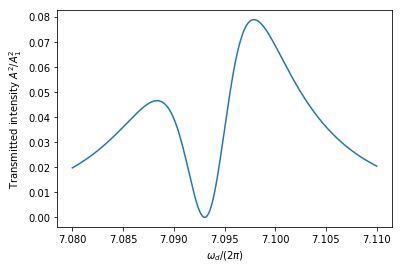

-30.0 dB


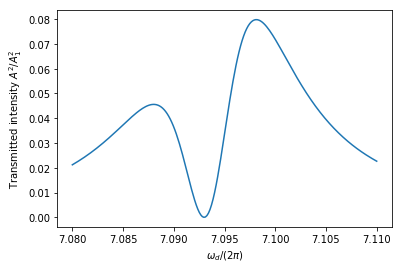

In [9]:
# Plot selected cuts
for i, xi_db in enumerate(xi_dbs):
    if int(xi_db) in range(-30, -70, -10):
        print xi_db, "dB"
        plt.xlabel('$\omega_d / (2 \pi)$')
        plt.ylabel('Transmitted intensity $A^2 / A^2_1$')
        try:
            plt.plot(omega_ds/(2*np.pi), results[i])
        except IndexError:
            plt.plot(omega_ds/(2*np.pi), results[-1])
        plt.show()

## Figure 3: Emergence of sqrt(n) peaks under strong driving of the vacuum Rabi transition

In [10]:
# Vary the driving force
xi_dbs = np.linspace(-50, -15, (50-15)*2+1)                     # Driving strengths
omega_ds = np.linspace(6.65, 7.2, 200) * 2 * np.pi        # Driving frequencies

In [11]:
# Find transmission amplitude for varying frequencies
results = []
pbar = ProgressBar(len(xi_dbs))
for i, xi_db in enumerate(xi_dbs):
    # Convert decibel to magnitude
    xi = 10**(xi_db/20)

    # Operators
    a = tensor(destroy(N_light), qeye(N_atom))
    sm = tensor(qeye(N_light), destroy(N_atom))
    
    # Solve master equation for different driving frequencies
    results.append([])
    for omega_d in omega_ds:
        # Hamiltonian
        H_res = (omega_r-omega_d) * a.dag() * a
        H_qub = (omega_r-omega_d) * sm.dag() * sm #sum([(omega_j(j)-omega_d) * j_braket(j,j) for j in range(N_atom)])
        H_int = g0_q1 * (a * sm.dag() + sm * a.dag()) #sum([g_j(j) * (a * j_braket(j+1,j) + j_braket(j,j+1) * a.dag()) for j in range(N_atom)])
        H_drv = xi * (a.dag() + a)
        H = H_res + H_qub + H_int + H_drv

        # Collapse operators
        damping = kappa * a
        relaxation = gamma_1 * alpha_j(0) * sm #gamma_1 * sum([alpha_j(j) * j_braket(j,j+1) for j in range(N_atom-1)])
        c_ops = [damping, relaxation]
        
        # Steady-state solution of master equation
        rho_s = steadystate(H, c_ops)
        results[-1].append(np.abs(expect(a, rho_s))**2)
    
    # Update progress bar
    pbar.update(i)

11.3%. Run time:  10.93s. Est. time left: 00:00:01:26
21.1%. Run time:  19.97s. Est. time left: 00:00:01:14
31.0%. Run time:  28.76s. Est. time left: 00:00:01:04
40.8%. Run time:  36.52s. Est. time left: 00:00:00:52
50.7%. Run time:  44.49s. Est. time left: 00:00:00:43
60.6%. Run time:  52.37s. Est. time left: 00:00:00:34
70.4%. Run time:  60.11s. Est. time left: 00:00:00:25
80.3%. Run time:  68.79s. Est. time left: 00:00:00:16
90.1%. Run time:  77.33s. Est. time left: 00:00:00:08


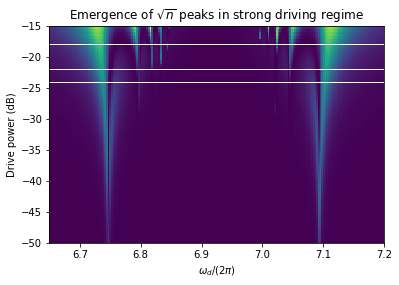

In [12]:
# Generate pseudocolor plot of transmission amplitude response over parameter space
plt.title('Emergence of $\sqrt{n}$ peaks in strong driving regime')
plt.xlabel('$\omega_d / (2 \pi)$')
plt.ylabel('Drive power (dB)')
plt.plot(omega_ds/(2*np.pi),[-24]*len(omega_ds), 'w', linewidth=1)
plt.plot(omega_ds/(2*np.pi),[-22]*len(omega_ds), 'w', linewidth=1)
plt.plot(omega_ds/(2*np.pi),[-18]*len(omega_ds), 'w', linewidth=1)
plt.pcolor(omega_ds/(2*np.pi), xi_dbs, results)
plt.show()

-24.5 dB


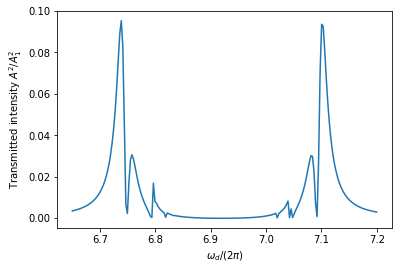

-24.0 dB


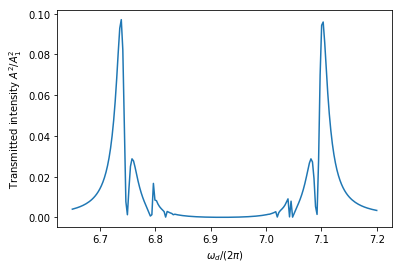

-22.5 dB


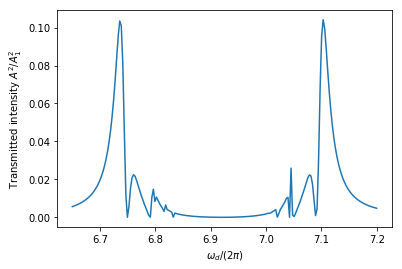

-22.0 dB


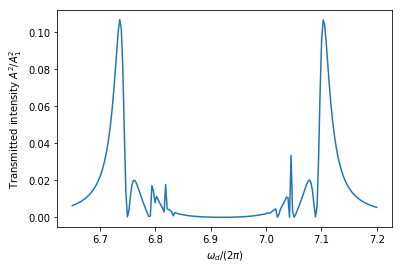

-18.5 dB


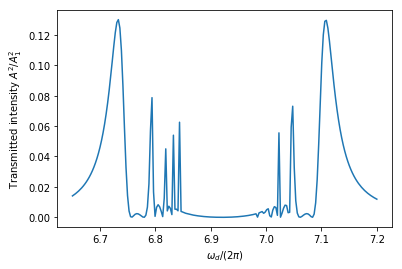

-18.0 dB


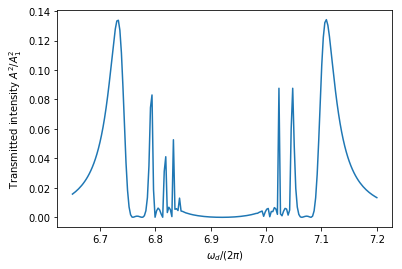

In [13]:
# Plot selected cuts
for i, xi_db in enumerate(xi_dbs):
    if int(xi_db) in [-24, -22, -18]:
        print xi_db, "dB"
        plt.xlabel('$\omega_d / (2 \pi)$')
        plt.ylabel('Transmitted intensity $A^2 / A^2_1$')
        plt.plot(omega_ds/(2*np.pi), results[i])
        plt.show()

## Versions

In [14]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.2.0
Numpy,1.14.3
SciPy,1.1.0
matplotlib,2.1.2
Cython,0.28.2
Number of CPUs,2
BLAS Info,OPENBLAS
IPython,5.4.1
Python,"2.7.14 |Anaconda, Inc.| (default, Dec 7 2017, 11:07:58) [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]"
OS,posix [darwin]
